In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Q3 Part A

In [14]:
def LOG(image_path, sigma=2, laplacian_kernel_size=3, threshold=15):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F, ksize=laplacian_kernel_size)
    edges = np.zeros_like(laplacian, dtype=np.uint8)
    

    for y in range(1, laplacian.shape[0] - 1):
        for x in range(1, laplacian.shape[1] - 1):
            current_pixel = laplacian[y, x]
            neighbors = [
                laplacian[y-1, x], laplacian[y+1, x],
                laplacian[y, x-1], laplacian[y, x+1], 
                laplacian[y-1, x-1], laplacian[y-1, x+1],
                laplacian[y+1, x-1], laplacian[y+1, x+1]
            ]
            if any((current_pixel * neighbor < 0) and (abs(current_pixel - neighbor) > threshold) for neighbor in neighbors):
                edges[y, x] = 255

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Laplacian of Gaussian")
    plt.imshow(laplacian, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Detected Edges")
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.show()

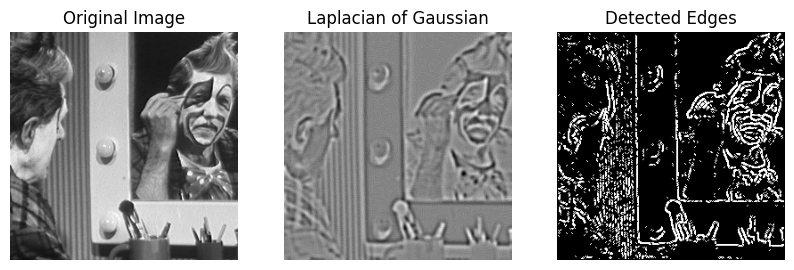

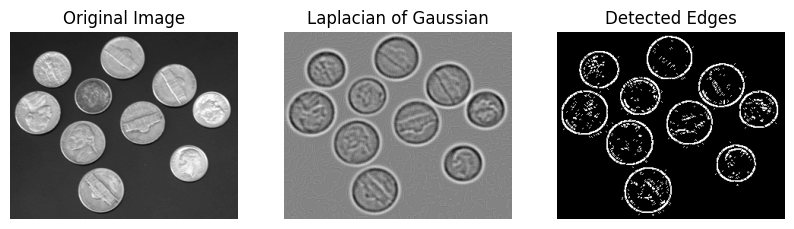

In [15]:

image_path1 = 'clown.png'
LOG(image_path1)
image_path2 = 'coins1.png'
LOG(image_path2)

Q3 Part B

In [16]:
def DOG(image_path, sigma1=1.6, sigma2=1):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gaussian1 = cv2.GaussianBlur(image, (0, 0), sigma1)
    gaussian2 = cv2.GaussianBlur(image, (0, 0), sigma2)
    dog = gaussian1 - gaussian2
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("DOG")
    plt.imshow(dog, cmap='gray')
    plt.axis('off')
    plt.show()

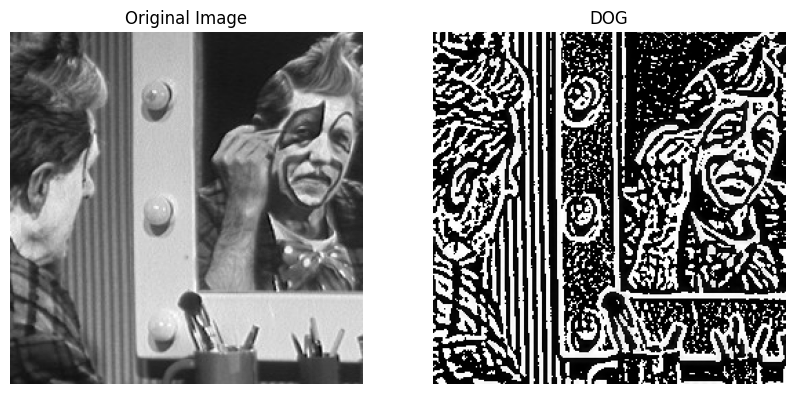

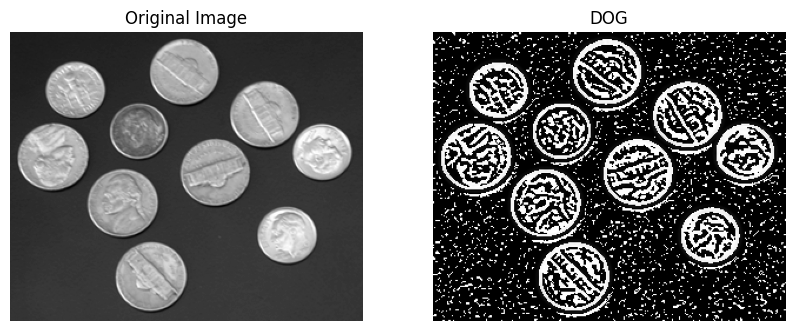

In [17]:
DOG(image_path1)
DOG(image_path2)

Q3 Part C

In [18]:
def canny_edge_detection(image_path, low_threshold=50, high_threshold=150):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, low_threshold, high_threshold)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edge Detection")
    plt.axis('off')
    
    plt.show()

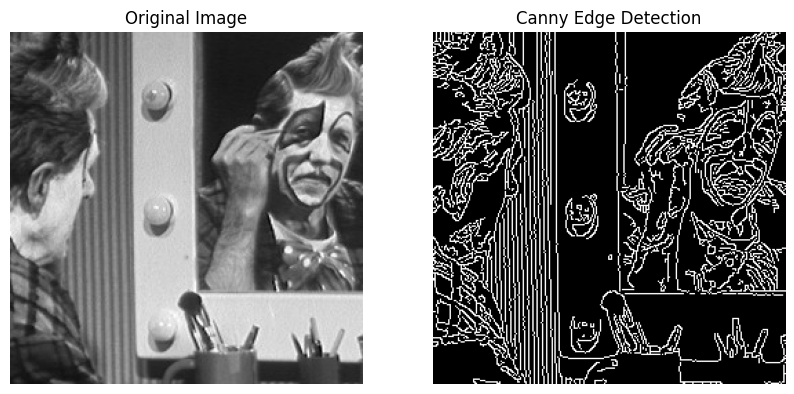

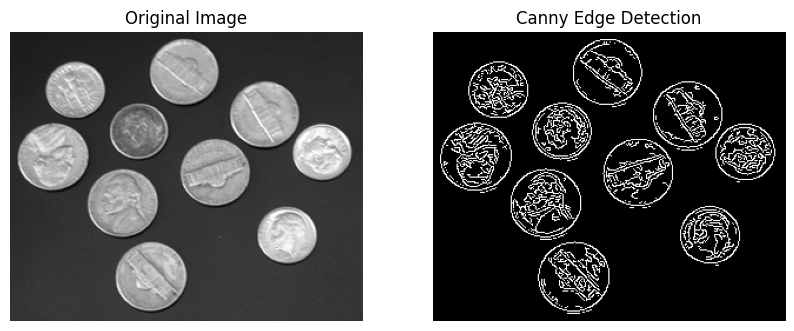

In [19]:
canny_edge_detection(image_path1)
canny_edge_detection(image_path2)

In [61]:
from collections import defaultdict

def custom_hough_circles(edges, radius_bins, spacing):
    min_radius, max_radius = radius_bins[0][0], radius_bins[-1][1]
    rows, cols = edges.shape
    accumulator = defaultdict(int)

    for y in range(rows):
        for x in range(cols):
            if edges[y, x] > 0:
                for r in range(min_radius, max_radius + 1):
                    for theta in range(0, 360, spacing):
                        a = int(x - r * np.cos(np.deg2rad(theta)))
                        b = int(y - r * np.sin(np.deg2rad(theta)))
                        if 0 <= a < cols and 0 <= b < rows:
                            accumulator[(a, b, r)] += 1

    circles = sorted(accumulator.items(), key=lambda x: x[1], reverse=True)
    return [(a, b, r) for (a, b, r), _ in circles]

def circular_hough_transform(image_path, spacing=10, radius_bins=[(10, 20), (20, 30)], k=8):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 50, 150)

    circles = custom_hough_circles(edges, radius_bins, spacing)

    if circles:
        circles = circles[:k+1]
        plt.figure(figsize=(8, 8))
        output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        for i, (x, y, r) in enumerate(circles):
            cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)
            cv2.circle(output_image, (x, y), 2, (0, 0, 255), 3)

        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Top {k} Detected Circles")
        plt.axis('off')
        plt.show()
    else:
        print("No circles were detected.")


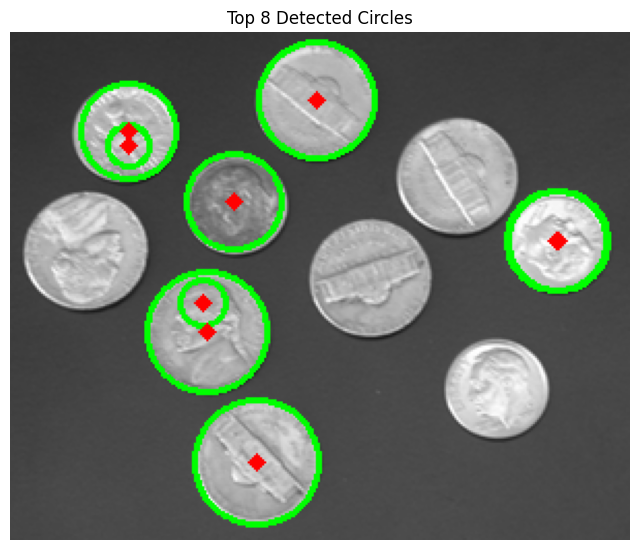

In [62]:
circular_hough_transform(image_path2)

Q4

Q4 Part A

In [22]:
def compute_histogram(image):
    histogram, _ = np.histogram(image, bins=256, range=(0, 256))
    return histogram

def otsu_thresholding(histogram):
    total_pixels = np.sum(histogram)
    sum_all = np.dot(np.arange(256), histogram)
    global_mean = sum_all / total_pixels
    
    max_between_class_variance = 0
    min_within_class_variance = float('inf')
    threshold = 0
    max_ratio = 0.0
    
    sum_b, weight_b = 0, 0
    
    for t in range(256):
        weight_b += histogram[t]
        if weight_b == 0:
            continue
        weight_f = total_pixels - weight_b
        if weight_f == 0:
            break
        
        sum_b += t * histogram[t]
        mean_b = sum_b / weight_b
        mean_f = (sum_all - sum_b) / weight_f

        P1 = weight_b / total_pixels
        P2 = weight_f / total_pixels
        
        var_b = np.dot((np.arange(t+1) - mean_b)**2, histogram[:t+1]) / weight_b
        var_f = np.dot((np.arange(t+1, 256) - mean_f)**2, histogram[t+1:]) / weight_f
        within_class_variance = P1 * var_b + P2 * var_f

        between_class_variance = P1 * ((mean_b - global_mean) ** 2) + P2 * ((mean_f - global_mean) ** 2)

        ratio = (between_class_variance)/(between_class_variance + within_class_variance)
        if ratio > max_ratio:
            max_ratio = ratio
            max_between_class_variance = between_class_variance
            min_within_class_variance = within_class_variance
            threshold = t
            

    return threshold, max_between_class_variance, min_within_class_variance


def kmeans_thresholding(histogram, max_iters=100):

    mean1, mean2 = 50, 200
    threshold = 0

    for _ in range(max_iters):
        cluster1 = [i for i in range(256) if abs(i - mean1) < abs(i - mean2)]
        cluster2 = [i for i in range(256) if abs(i - mean2) <= abs(i - mean1)]
        
        mean1_new = np.sum([i * histogram[i] for i in cluster1]) / np.sum([histogram[i] for i in cluster1]) if np.sum([histogram[i] for i in cluster1]) != 0 else mean1
        mean2_new = np.sum([i * histogram[i] for i in cluster2]) / np.sum([histogram[i] for i in cluster2]) if np.sum([histogram[i] for i in cluster2]) != 0 else mean2

        if (abs(mean1 - mean1_new) / mean1) < 0.01 and (abs(mean2 - mean2_new) / mean2) < 0.01:
            break
        
        mean1, mean2 = mean1_new, mean2_new
    

    threshold = (mean1 + mean2) / 2

    total_pixels = np.sum(histogram)
    weight1 = np.sum([histogram[i] for i in cluster1]) / total_pixels
    weight2 = np.sum([histogram[i] for i in cluster2]) / total_pixels

    within_class_variance1 = np.sum([(i - mean1) ** 2 * histogram[i] for i in cluster1]) / np.sum([histogram[i] for i in cluster1]) if np.sum([histogram[i] for i in cluster1]) != 0 else 0
    within_class_variance2 = np.sum([(i - mean2) ** 2 * histogram[i] for i in cluster2]) / np.sum([histogram[i] for i in cluster2]) if np.sum([histogram[i] for i in cluster2]) != 0 else 0
    within_class_variance = weight1 * within_class_variance1 + weight2 * within_class_variance2

    global_mean = np.dot(np.arange(256), histogram) / total_pixels

    between_class_variance = weight1 * (mean1 - global_mean) ** 2 + weight2 * (mean2 - global_mean) ** 2

    return int(threshold), mean1, mean2, within_class_variance, between_class_variance



Otsu's Method: Threshold = 42, Between-Class Variance = 693.8300285196959, Within-Class Variance = 397.10443971363355
k-Means Method: Threshold = 43, Mean1 = 15.044552826597554, Mean2 = 71.5253290678386, Within-Class Variance = 397.1170367677733, Between-Class Variance = 693.8174314655562


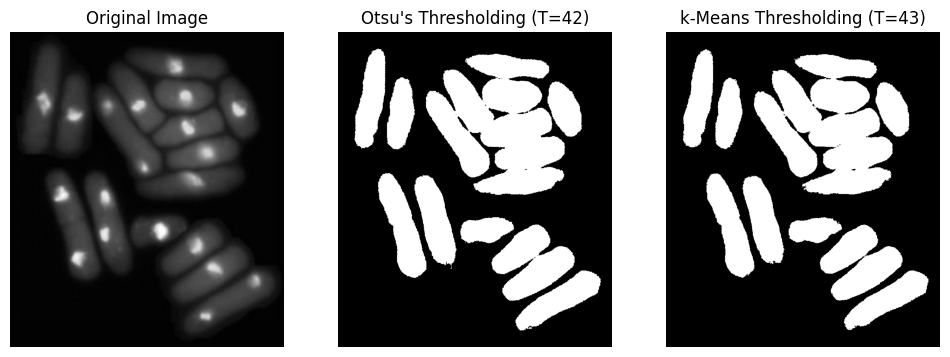

In [23]:

image_path = 'yeast.tif'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

histogram = compute_histogram(image)

otsu_thresh, otsu_bc_variance, otsu_wc_variance = otsu_thresholding(histogram)
print(f"Otsu's Method: Threshold = {otsu_thresh}, Between-Class Variance = {otsu_bc_variance}, Within-Class Variance = {otsu_wc_variance}")

kmeans_thresh, mean1, mean2, kmeans_wc_variance, kmeans_bc_variance = kmeans_thresholding(histogram)
print(f"k-Means Method: Threshold = {kmeans_thresh}, Mean1 = {mean1}, Mean2 = {mean2}, Within-Class Variance = {kmeans_wc_variance}, Between-Class Variance = {kmeans_bc_variance}")

_, otsu_binary = cv2.threshold(image, otsu_thresh, 255, cv2.THRESH_BINARY)
_, kmeans_binary = cv2.threshold(image, kmeans_thresh, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(otsu_binary, cmap='gray')
plt.title(f"Otsu's Thresholding (T={otsu_thresh})")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(kmeans_binary, cmap='gray')
plt.title(f"k-Means Thresholding (T={kmeans_thresh})")
plt.axis('off')

plt.show()

Q4 Part B

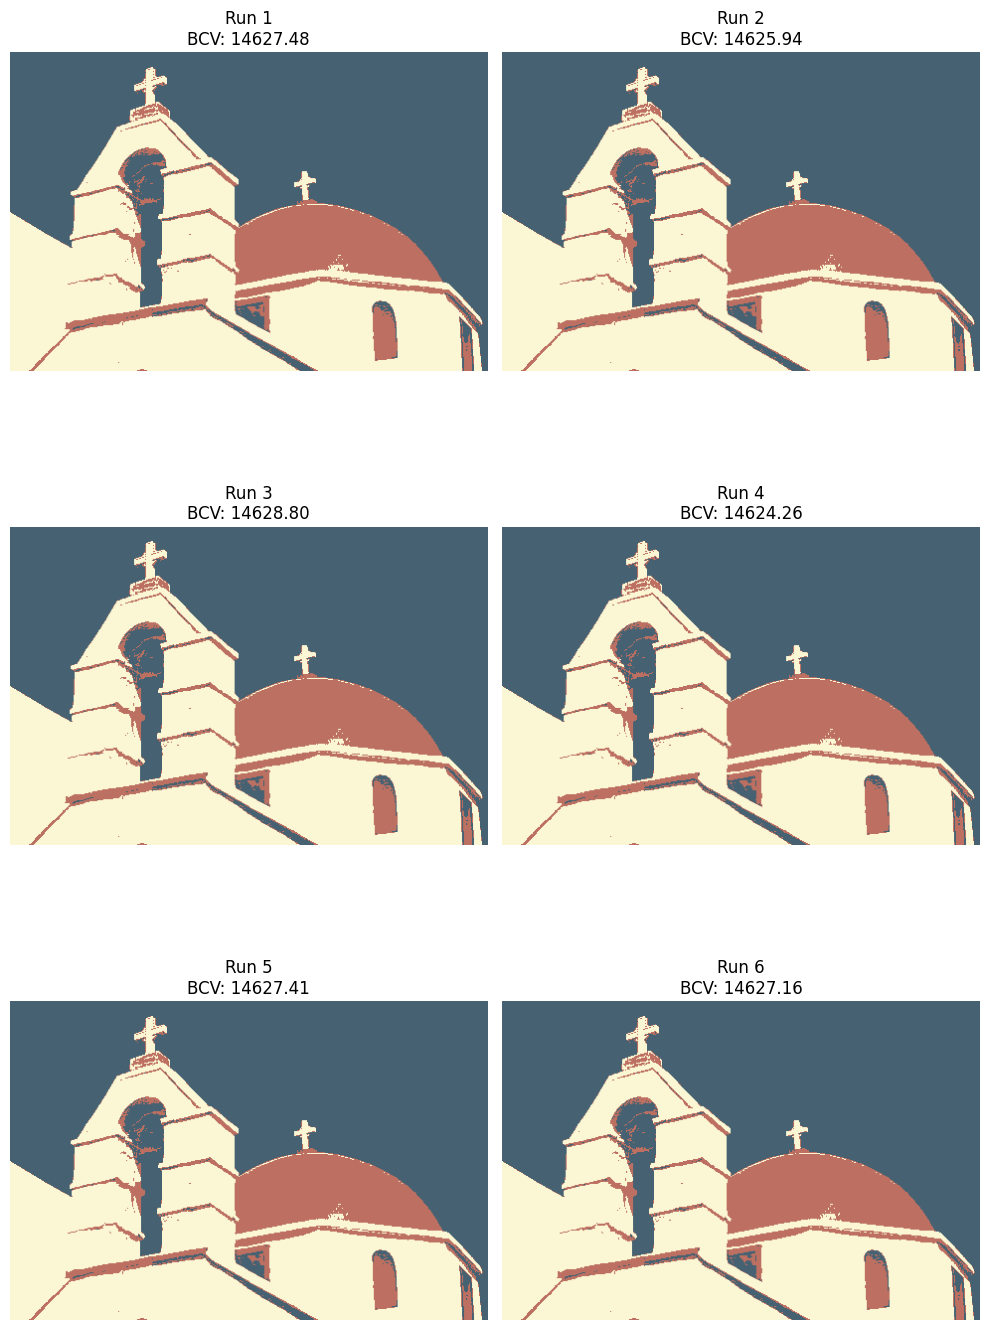

Between-Class Variances for each run:
Run 1: BCV = 14627.48
Run 2: BCV = 14625.94
Run 3: BCV = 14628.80
Run 4: BCV = 14624.26
Run 5: BCV = 14627.41
Run 6: BCV = 14627.16

Observation: Higher variability in BCVs and visual outputs may indicate sensitivity to initialization.


In [ ]:

image_path = '118035.jpg'
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixels = image.reshape(-1, 3)

k = 3
n_runs = 6

results = []
bcvs = []

def calculate_bcv(labels, centroids, overall_mean, N):
    bcv = 0
    for i in range(len(centroids)):
        cluster_size = np.sum(labels == i)
        centroid = centroids[i]
        bcv += (cluster_size / N)* np.linalg.norm(centroid - overall_mean) ** 2
    return bcv

for run in range(n_runs):
    kmeans = KMeans(n_clusters=k, init='random', n_init=1, random_state=run)
    kmeans.fit(pixels)
    
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    clustered_image = centroids[labels].reshape(image.shape).astype(np.uint8)

    overall_mean = np.mean(pixels, axis=0)

    bcv = calculate_bcv(labels, centroids, overall_mean, len(pixels))

    results.append((clustered_image, bcv))
    bcvs.append(bcv)

import math
images_per_row = 2
n_rows = math.ceil(n_runs / images_per_row)

fig, axes = plt.subplots(n_rows, images_per_row, figsize=(10, 5 * n_rows))
axes = axes.flatten()

for i, (clustered_image, bcv) in enumerate(results):
    axes[i].imshow(clustered_image)
    axes[i].set_title(f'Run {i+1}\nBCV: {bcv:.2f}')
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

print("Between-Class Variances for each run:")
for i, bcv in enumerate(bcvs):
    print(f"Run {i+1}: BCV = {bcv:.2f}")

Part C

In [ ]:
from skimage import color
from skimage.segmentation import mark_boundaries

def slic_superpixels(image, s=15, num_iterations=10):

    lab_image = color.rgb2lab(image)
    h, w = lab_image.shape[:2]
    d_cm = s
    d_sm = s
    
    num_superpixels = (h // s) * (w // s)
    S = s
    centers = []
    label = -np.ones((h, w), dtype=int)
    distance = np.full((h, w), np.inf)

    for y in range(S // 2, h, S):
        for x in range(S // 2, w, S):
            L, a, b = lab_image[y, x]
            centers.append([x, y, L, a, b])
    
    centers = np.array(centers)
    num_centers = centers.shape[0]
    
    for iteration in range(num_iterations):
        for i, (cx, cy, cL, ca, cb) in enumerate(centers):
            x_min, x_max = max(cx - S, 0), min(cx + S, w)
            y_min, y_max = max(cy - S, 0), min(cy + S, h)
            
            for x in range(int(x_min), int(x_max)):
                for y in range(int(y_min), int(y_max)):
                    L, a, b = lab_image[y, x]

                    d_color = np.sqrt((L - cL)**2 + (a - ca)**2 + (b - cb)**2)
                    d_spatial = np.sqrt((x - cx)**2 + (y - cy)**2)

                    D = np.sqrt( (d_color/d_cm)**2 + (d_spatial/d_sm)**2)

                    if D < distance[y, x]:
                        distance[y, x] = D
                        label[y, x] = i

        new_centers = np.zeros_like(centers)
        counts = np.zeros(num_centers, dtype=int)
        
        for y in range(h):
            for x in range(w):
                cluster_id = label[y, x]
                if cluster_id != -1:
                    new_centers[cluster_id, :2] += [x, y]
                    new_centers[cluster_id, 2:] += lab_image[y, x]
                    counts[cluster_id] += 1
        
        for i in range(num_centers):
            if counts[i] > 0:
                new_centers[i] /= counts[i]
        
        if np.allclose(centers, new_centers, atol=1e-2):
            break
        
        centers = new_centers

    segmented_image = np.zeros_like(lab_image)
    for i in range(num_centers):
        mask = (label == i)
        segmented_image[mask] = centers[i, 2:]
    
    segmented_image_rgb = color.lab2rgb(segmented_image)

    edge_image = mark_boundaries(image, label, color=(1, 0, 0))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(segmented_image_rgb)
    ax[0].set_title("Segmented Image with Cluster Means")
    ax[0].axis("off")
    
    ax[1].imshow(edge_image)
    ax[1].set_title("Superpixel Edges")
    ax[1].axis("off")
    
    plt.show()
    
    return segmented_image_rgb, edge_image



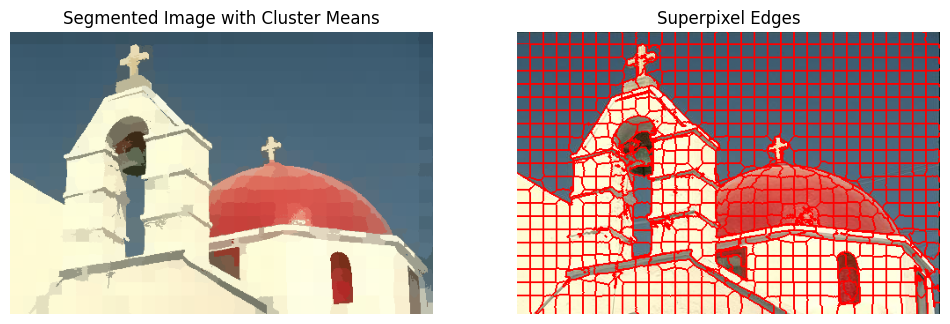

In [ ]:

image = cv2.imread('118035.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

s = 15
segmented_image, edge_image = slic_superpixels(image, s=s)
